# Analysis about fuel cycle scenarios for HALEU fueled reactors

The purpose of this notebook is to compare the results of using the updated 
function transition_metrics.add_receiver_prototype, which avoids the creation 
and use of the Materials metric to create the TransactionQuantity metric. This analysis 
of this notebook compares the results of analysis of a fuel cycle to what is 
reported in [this published article](https://www.epj-n.org/articles/epjn/full_html/2021/01/epjn210024/epjn210024.html).

1 total fuel cycle scenario is considered for this work:
* Scenario 1: Current US fuel cycle


Results include the mass of enriched uranium, and the total SWU capacity 
required in each scenario. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../../../scripts/')

In [2]:
import cymetric as cym
import transition_metrics as tm

In [3]:
current_outfile = 'united_states_2020.sqlite'

## Material Transactions

In [4]:
# All transactions
current_transactions = tm.add_receiver_prototype(current_outfile)

In [5]:
# Obtaining just the fresh_uox transactions for each scenario
current_uox = tm.commodity_mass_traded(current_transactions, 'fresh_uox')

### Plotting material transactions

Text(0.5, 1.0, 'Mass of uranium supplied to all reactors')

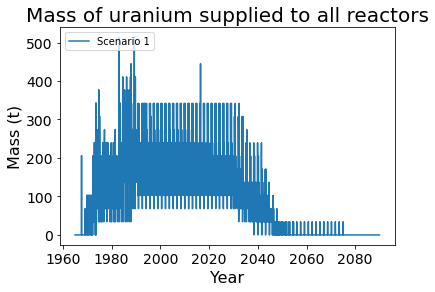

In [6]:
# Comparing fresh_uox transactions to all reactors
plt.figure()

plt.plot(current_uox['Year'], current_uox['Quantity']/1000, 
         label='Scenario 1')
plt.legend(loc=2)
plt.ylabel('Mass (t)', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Mass of uranium supplied to all reactors', fontsize=20)

In [13]:
print('average = ', current_uox['Quantity'].mean()/1000)
print('maximum = ', current_uox['Quantity'].max()/1000)
print('average prior to 2025 = ', current_uox['Quantity'][0:721].mean()/1000)
print('total after 2025 = ', current_uox['Quantity'][721:].cumsum()[1499]/1000)

average =  96.0179391424616
maximum =  513.7178423236442
average prior to 2025 =  157.60225251926428
total after 2025 =  30395.68464730291


Reported values in article:
* 96.2 MTU/month average
* 513.7 MTU max
* 157.6 MTU/month average prior to 2025
* 30,635.0 MTU total after 2025

In [23]:
current_energy = tm.get_annual_electricity(current_outfile)
current_energy[55:60]

,Year,Energy
55,2022,90.417083
56,2023,90.846333
57,2024,90.137500
58,2025,90.874000
59,2026,90.545083


Reported energy produced: 91.82 GWe-yr

There is some discrepancy present in these results, stemming from the mass of
uranium after 2025 (based on the averages prior to 2025 matching). Part of the 
discrepancy comes from a difference in the amount of energy produced (91.82GWe-yr 
in 2025 per the article, and 90.87 GWe-yr in 2025 per this dataset). 

From this, I feel like there is a difference in the number of LWRs that are deployed
that is causing the difference in the results

In [39]:
current_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
current_lwrs = tm.get_lwr_totals(current_outfile, current_nonlwr)
current_lwrs = tm.add_year(current_lwrs)
current_lwrs[['Year','lwr_total']][721:]

Prototype,Year,lwr_total
721,2025.08,93.0
722,2025.17,93.0
723,2025.25,93.0
724,2025.33,93.0
725,2025.42,93.0
...,...,...
1495,2089.58,0.0
1496,2089.67,0.0
1497,2089.75,0.0
1498,2089.83,0.0


There are 93 LWRs deployed in January 2025 for this output file, but there is 
no published value to compare this against. 

## SWU Calculations
SWU = (P*V(x_p) + T*V(x_t) - F*V(x_f))*t

V(x_i) = (2*x_i-1)*ln(x_i/(1-x_i))

In [9]:
#Defining assays for LEU product, tails, and feed material
leu_p = 0.045
mmr_p = 0.13
xe_p = 0.155
x_f = 0.00711
x_t = 0.002

### Total SWU

In [10]:
# Scenario 1
current_tails = tm.calculate_tails(current_uox['Quantity'], leu_p, x_t, x_f)
current_feed = tm.calculate_feed(current_uox['Quantity'], current_tails)
current_swu = tm.calculate_SWU(current_uox['Quantity'], leu_p, 
                               current_tails, x_t, 
                               current_feed, x_f)
current_swu = current_swu.to_frame().reset_index()
current_swu = current_swu.rename(columns={'Quantity':'SWU', 'index':'Time'})
current_swu = tm.add_year(current_swu)

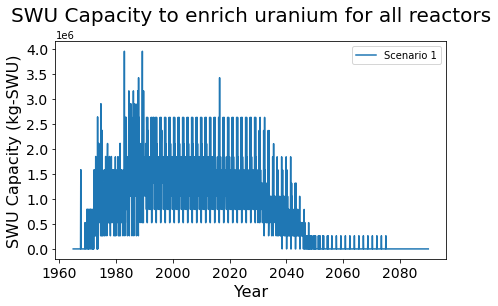

In [11]:
plt.figure(figsize=(7,4))
plt.plot(current_swu['Year'], current_swu['SWU'], label='Scenario 1')

plt.xlabel('Year', fontsize=16)
plt.ylabel('SWU Capacity (kg-SWU)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
title = plt.title('SWU Capacity to enrich uranium for all reactors', fontsize=20, pad=20)
plt.legend()

In [12]:
print('average = ', current_swu['SWU'].mean())
print('maximum = ', current_swu['SWU'].max())
print('average prior to 2025 = ', current_swu['SWU'][:721].mean())
print('average after 2025 = ', current_swu['SWU'][721:].mean())
print('total = ', current_swu['SWU'].cumsum()[1499])
print('total after 2025 = ', current_swu['SWU'][721:].cumsum()[1499])

average =  738424.1657129074
maximum =  3950737.4613283835
average prior to 2025 =  1212037.1762858185
average after 2025 =  300073.74129305035
total =  1107636248.5693555
total after 2025 =  233757444.46728557


Reported values in article:
* average = 0.74e6 kg-SWU/month
* maximum = 3.95e6 kg-SWU
* average prior to 2025 = 1.21e6 kg-SWU/month
* average after 2025 = 0.302e6 kg-SWU/month
* total = 11.1e8 kg-SWU
* total after 2025 = 2.36e8 kg-SWU

A similar pattern is observed. The average SWu capacity before 2025 is the same, but they differ 
after 2025. This difference is not surprising, as the SWU capacity is calculated based on 
the mass of uranium so any errors propogate forward through this calculation. 